In [1]:
import numpy as np
import pandas as pd
import math

# Function to generate X where
# Xi = -1 with probability 1/2 and Xi = 1 with probability 1/2
def generate_X(size):
    # Initialize an array of size 16, X0 = 0, 
    # Values lie from X1 through X15
    X = np.zeros((size,16))
    #For X1 to X15
    for i in range(size):
        for j in range(1,16):
            # Get a random number which is either 0 or 1
            x = np.random.choice(2)
            # If it is 0, Xi = -1, if it is 1, Xi = 1
            # So we populate X with probability 1/2
            X[i][j] = -1 if x == 0 else 1
    return X

# Function to generate training and testing data set using X and sigma
def generate_data(X,sigma):
    size = len(X)
    Y = np.zeros(size)
    N = np.random.normal(0,sigma**2,size)
    # Populate the array using the given function for Y
    for i in range(size):
        y = 0.9*X[i][1] + (0.9**2)*X[i][2] + (0.9**3)*X[i][3] + (0.9**4)*X[i][4] + (0.9**5)*X[i][5] + N[i]
        Y[i] = np.sign(y)
    return Y

# Function to get heuristic given the data set

def calculate_IG(X,Y):
    #print(X,Y)
    # Count occurence of element '1' in Y
    count = np.count_nonzero(Y==1)
    #print(count)
    # P(Y == 1):
    Py1 = count/len(Y)
    # P(y == -1):
    Py2 = 1-Py1
    #print(Py1)
    # H(Y):
    if Py1 == 0 and Py2 != 0:
         H_Y = -Py2 * math.log(Py2,2)
    elif Py1 != 0 and Py2 == 0:
        H_Y = -Py1 * math.log(Py1,2)
    elif Py1 == 0 and Py2 == 0:
         H_Y = 0 
    else:
        H_Y = -Py1 * math.log(Py1,2) - Py2 * math.log(Py2,2)
    # IG(Xi)
    IG = np.zeros(X.shape[1])
    # Occurences of +1 in Xi
    x1 = np.count_nonzero(X == 1, axis = 0)
    for i in range(1,X.shape[1]):
        # Ignore column already splitted on
        if x1[i] == len(X) or x1[i] == 0:
            continue
        # P(Xi == +1)
        P_X1 = x1[i]/len(X)
        # P(Xi == -1)
        P_X2 = 1 - P_X1
        # Occurences:
        y1_x1 = 0
        y1_x2 = 0
        y2_x1 = 0
        y2_x2 = 0
        for j in range(len(X)):
            if Y[j]==1 and X[j][i]==1:
                y1_x1 += 1
            if Y[j]==1 and X[j][i]==-1:
                y1_x2 += 1
            if Y[j]==-1 and X[j][i]==1:
                y2_x1 += 1
            if Y[j]==-1 and X[j][i]==-1:
                y2_x2 += 1
        # P(Y==+1|Xi==+1)
        P_Y1_X1 = y1_x1/x1[i] 
        # P(Y==+1|Xi==-1)
        P_Y1_X2 = y1_x2/(len(X)-x1[i])
        # P(Y==-1|Xi==+1)
        P_Y2_X1 = y2_x1/x1[i]
        # P(Y==-1|Xi==-1)
        P_Y2_X2 = y2_x2/(len(X)-x1[i])
        # H(Y|Xi==+1)
        #print(P_Y1_X1,P_Y1_X2,P_Y2_X1,P_Y2_X2)
        if P_Y1_X1 == 0 and P_Y2_X1 != 0:
            H_Y_X1 = - P_Y2_X1*math.log(P_Y2_X1,2)
        elif P_Y2_X1 == 0 and P_Y1_X1 != 0:
             H_Y_X1 = -P_Y1_X1*math.log(P_Y1_X1,2)
        elif P_Y2_X1 == 0 and P_Y1_X1 == 0:
             H_Y_X1 = 0
        else:
            H_Y_X1 = -P_Y1_X1*math.log(P_Y1_X1,2) - P_Y2_X1*math.log(P_Y2_X1,2)
        # H(Y|Xi==-1)
        if P_Y1_X2 == 0 and P_Y2_X2 != 0:
             H_Y_X2 = -P_Y2_X2*math.log(P_Y2_X2,2)
        elif P_Y2_X2 == 0 and P_Y1_X2 != 0:
            H_Y_X2 = -P_Y1_X2*math.log(P_Y1_X2,2)
        elif P_Y1_X2 == 0 and P_Y2_X2 == 0:
            H_Y_X2 = 0
        else:
            H_Y_X2 = -P_Y1_X2*math.log(P_Y1_X2,2) - P_Y2_X2*math.log(P_Y2_X2,2)
        # H(Y|Xi)
        H_Y_X = P_X1 * H_Y_X1 + P_X2 * H_Y_X2
        # IG(Xi)
        IG[i] = H_Y - H_Y_X
    return IG

In [2]:
def split_data(data):
    # Calculate IG's
    IG = calculate_IG(data[:,:(data.shape[1]-1)],data[:,-1:])
    # Find index with largest IG
    split_index = np.argmax(IG)
    if split_index == 0:
        split_index = 1
    # Split on that index
    first_half = data[data[:,split_index]==1]
    second_half = data[data[:,split_index]==-1]
    return first_half,second_half,split_index,IG

# Function to check stopping conditions
def process_half(data,size):
    # No. of Yi=+1 in the data set
    count = np.count_nonzero(data[:,-1:] == 1)
    # If sample size threshold met
    if len(data) <= size:
        # +1 is majority
        if count >= len(data)-count:
            return 1
        # Otherwise => -1 majority
        return -1
    # If all Yi's are +1
    if count == len(data):
        return 1
    # If all Yi's are -1
    if count == 0:
        return -1
    
    # If we did not hit a leaf node:
    return 0



In [3]:
from collections import defaultdict
global res_dict 
res_dict = defaultdict()
def build(half,size):
    global res_dict
    half = half.astype(int)
    print('Sample Size: ', len(half))
    #print(half)
    #print(half.shape)
    if len(half) == 0:
        print('return')
        print()
        return
    if len(half) == 1:
        print('return',half[0][-1])
        print()
        if half[0][0] in res_dict:
            return
        res_dict[half[0][0]] = half[0][-1]
        return half
    # No. of Yi=+1 in the data set
    count = np.count_nonzero(half[:,-1:] == 1)
    count2 = np.count_nonzero(half[:,-1:] == -1)
    # If sample size threshold met
    if len(half) <= size:
        print('Size Threshold Met')
        print('+1: ',count,'-1: ', count2)
        # +1 is majority
        if count >= count2:
            res = 1
        # Otherwise => -1 majority
        else:
            res = -1
        half[:,-1] = res
        print('return',res)
        print()
        for i in range(len(half)):
            if half[i][0] not in res_dict:
                res_dict[half[i][0]] = half[i][-1]
        return half
    # If all Yi's are +1 or -1
    if count == len(half) or count == 0:
        print('return',half[0][-1])
        print()
        for i in range(len(half)):
            if half[i][0] not in res_dict:
                res_dict[half[i][0]] = half[i][-1]
        return half
    # If we did not hit the stopping condition:
    first_half,second_half,split_index,IG = split_data(half)
    print('IG: ',IG)
    print('Split at ', split_index)
    print()
    build(first_half,size)
    build(second_half,size)

In [4]:
def calculate_miss(Y):
    global res_dict
    count = 0
    for i in range(len(Y)):
        if Y[i] != res_dict[i]:
            count += 1
    return count

In [5]:
def q1_1():
    global res_dict
    misses = np.zeros(100)
    # Generate data and call build 
    X = generate_X(5000)
    training = generate_data(X,0.05)
    training = [[x] for x in training]
    dat = np.append(X,training,1)
    dat[:,0] = np.arange(len(dat))
    for i in range(0,5000,50):
        # Change sample size
        build(dat,i)
        misses[i//50] = calculate_miss(dat[:,-1]);
        res_dict = defaultdict()
    return misses

In [6]:
misses = q1_1();

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
IG:  [0.00000000e+00 1.27667392e-01 0.00000000e+00 1.21441804e-01
 1.28535129e-01 0.00000000e+00 4.01613699e-04 8.56106763e-04
 3.65515588e-04 3.22180814e-04 1.35790940e-03 1.33825980e-04
 1.56726302e-03 1.80049205e-03 1.92503041e-04 1.07562730e-06]
Split at  4

Sample Size:  675
return 1

Sample Size:  641
IG:  [0.00000000e+00 3.08130909e-01 0.00000000e+00 2.87573227e-01
 0.00000000e+00 0.00000000e+00 2.10716662e

IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99722648e-01
 0.00000000e+00 0.00000000e+00 5.98657992e-03 2.73854665e-04
 

IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
IG:  [0.00000000e+00 1.27667392e-01 0.00000000e+00 1.21441804e-01
 1.28535129e-01 0.00000000e+00 4.01613699e-04 8.56106763e-04
 3.65515588e-04 3.22180814e-04 1.35790940e-03 1.33825980e-04
 1.56726302e-03 1.80049205e-03 1.92503041e-04 1.07562730e-06]
Split at  4

Sample Size:  675
return 1

Sample Size:  641
IG:  [0.00000000e+00 3.08130909e-01 0.00000000e+00 2.87573227e-01
 0.00000000e+00 0.00000000e+00 2.10716662e-03 1.17241262e-03


IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99722648e-01
 0.00000000e+00 0.00000000e+00 5.98657992e-03 2.73854665e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.74478019e-01 2.70135535e-01 2.37612648e-03 2.02303891e-04
 3.01141192e-04 9.16774399e-05 1.01142473e-03 2.37612648e-03
 9.16244346e-04 6.17940650e-03 4.24491417e-05 7.87160380e-04]
Split at  4

Sample Size:  291
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.92824111e-01 3.83410768e-03 2.60208584e-04
 4.36145308e-03 3.20778007e-04 7.04891397e-03 6.90521631e-03
 6.17913491e-03 1.61486452e-02 4.22875753e-06 6.71634717e-03]
Split at  5

Sample Size:  131
Size Threshold Met
+1:  131 -1:  0
return 1

Sample Size:  160
Size Threshold Met
+1:  0 -1:  160
return -1

Sample Size:  301
return -1

Sample Size:  617
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Sp

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
Size Threshold Met
+1:  331 -1:  0
return 1

Sample Size:  306
Size Threshold Met
+1:  156 -1:  150
return 1

Sample Size:  609
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03803677e-01
 0.00000000e+00 3.00661965e-01 1.77828192e-04 4.10794183e-05
 3.10727585e-04 1.94690301e-05 6.06251716e-04 9.94428030e-04
 1.02783342e-03 2.21452246e-04 4.10794183e-05 6.63595925e-06]
Split at  3

Sample Size:  294
Size Threshold Met
+1:  143 -

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
Size Threshold Met
+1:  331 -1:  0
return 1

Sample Size:  306
Size Threshold Met
+1:  156 -1:  150
return 1

Sample Size:  609
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03803677e-01
 0.00000000e+00 3.00661965e-01 1.77828192e-04 4.10794183e-05
 3.10727585e-04 1.94690301e-05 6.06251716e-04 9.94428030e-04
 1.02783342e-03 2.21452246e-04 4.10794183e-05 6.63595925e-06]
Split at  3

Sample Size:  294
Size Threshold Met
+1:  143 -

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82232343e-01
 0.00000000e+00 3.07196970e-01 4.75973225e-04 7.23321095e-05
 2.51189911e-03 8.34929826e-04 2.89204225e-04 5.20834548e-03
 8.53375411e-05 1.26266313e-03 2.30613290e-04 1.65599360e-03]
Split at  5

Sample Size:  331
Size Threshold Met
+1:  331 -1:  0
return 1

Sample Size:  306
Size Threshold Met
+1:  156 -1:  150
return 1

Sample Size:  609
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03803677e-01
 0.00000000e+00 3.00661965e-01 1.77828192e-04 4.10794183e-05
 3.10727585e-04 1.94690301e-05 6.06251716e-04 9.94428030e-04
 1.02783342e-03 2.21452246e-04 4.10794183e-05 6.63595925e-06]
Split at  3

Sample Size:  294
Size Threshold Met
+1:  143 -

IG:  [0.00000000e+00 2.01605877e-01 0.00000000e+00 1.82638009e-01
 2.01645515e-01 0.00000000e+00 1.32788922e-06 2.78155250e-04
 1.82401179e-05 7.02220822e-04 2.20208446e-04 8.27786535e-05
 1.33564736e-05 1.69525294e-05 1.19237259e-03 3.66189859e-03]
Split at  4

Sample Size:  637
Size Threshold Met
+1:  487 -1:  150
return 1

Sample Size:  592
Size Threshold Met
+1:  147 -1:  445
return -1

Sample Size:  2455
IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
Size Threshold Met
+1:  

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.21562372e-01
 1.20373117e-01 1.20077218e-01 8.14896957e-04 2.70431607e-04
 6.00769448e-04 4.26339324e-04 2.51046556e-04 1.47083634e-03
 9.65541682e-06 4.19307433e-03 3.39040226e-05 1.16652070e-04]
Split at  3

Sample Size:  592
Size Threshold Met
+1:  131 -1:  461
return -1

Sample Size:  617
Size Threshold Met
+1:  0 -1:  617
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
IG:  [0.00000000e+00 1.2

IG:  [0.00000000e+00 2.01605877e-01 0.00000000e+00 1.82638009e-01
 2.01645515e-01 0.00000000e+00 1.32788922e-06 2.78155250e-04
 1.82401179e-05 7.02220822e-04 2.20208446e-04 8.27786535e-05
 1.33564736e-05 1.69525294e-05 1.19237259e-03 3.66189859e-03]
Split at  4

Sample Size:  637
Size Threshold Met
+1:  487 -1:  150
return 1

Sample Size:  592
Size Threshold Met
+1:  147 -1:  445
return -1

Sample Size:  2455
IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73601584e-01
 2.13023704e-01 1.91888311e-01 2.31036939e-04 4.75227393e-05
 3.05459559e-06 1.45087081e-03 6.64167280e-05 4.65562231e-04
 5.71787032e-06 1.44863807e-03 3.59741426e-04 1.36355409e-03]
Split at  4

Sample Size:  637
Size Threshold Met
+1:  

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.21562372e-01
 1.20373117e-01 1.20077218e-01 8.14896957e-04 2.70431607e-04
 6.00769448e-04 4.26339324e-04 2.51046556e-04 1.47083634e-03
 9.65541682e-06 4.19307433e-03 3.39040226e-05 1.16652070e-04]
Split at  3

Sample Size:  592
Size Threshold Met
+1:  131 -1:  461
return -1

Sample Size:  617
Size Threshold Met
+1:  0 -1:  617
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
IG:  [0.00000000e+00 1.2

IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
Size Threshold Met
+1:  630 -1:  616
return 1

Sample Size:  1209
Size Threshold Met
+1:  131 -1:  1078
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
Size Threshold Met
+

IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
Size Threshold Met
+1:  1167 -1:  149
return 1

Sample Size:  1229
Size Threshold Met
+1:  634 -1:  595
return 1

Sample Size:  2455
IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
Size Threshold Met
+1

IG:  [0.00000000e+00 1.41924595e-01 0.00000000e+00 1.08723296e-01
 1.31709604e-01 1.19645325e-01 5.14671788e-05 3.95751718e-05
 1.86331543e-05 1.66482954e-03 3.32629616e-05 1.99545551e-05
 8.07382127e-05 2.87654785e-05 3.86191585e-04 4.21126993e-04]
Split at  1

Sample Size:  1246
Size Threshold Met
+1:  630 -1:  616
return 1

Sample Size:  1209
Size Threshold Met
+1:  131 -1:  1078
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
IG:  [0.00000000e+00 1.21911677e-01 0.00000000e+00 1.12051501e-01
 1.23329938e-01 1.25676657e-01 1.15730958e-09 6.70276452e-04
 2.30143022e-05 1.26719573e-04 1.16713912e-04 1.09972341e-04
 5.35668908e-04 3.93451553e-04 2.34054100e-04 1.00487979e-03]
Split at  5

Sample Size:  1316
Size Threshold Met
+

IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
Size Threshold Met
+1:  1801 -1:  744
return 1

Sample Size:  2455
Size Threshold Met
+1:  761 -1:  1694
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
Size Threshold Met
+1:  1801 -1:  744
return 1

Sample Size:  2455
Size Threshold Met
+1:  761 -1:  1694
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.432880

IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
Size Threshold Met
+1:  1801 -1:  744
return 1

Sample Size:  2455
Size Threshold Met
+1:  761 -1:  1694
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.43288094e-04 9.54795954e-06
 3.80625067e-04 1.20474529e-04 2.01523528e-04 5.58148409e-07]
Split at  2

Sample Size:  2545
Size Threshold Met
+1:  1801 -1:  744
return 1

Sample Size:  2455
Size Threshold Met
+1:  761 -1:  1694
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.09156438e-01 1.17313088e-01 9.28526234e-02
 1.07348299e-01 1.04840827e-01 4.08907146e-06 1.98165066e-04
 2.18974663e-05 4.59499729e-04 1.432880

In [7]:
print(misses)

[   0.    0.    0.    0.    0.    0.  567.  866.  866.  866.  866.  866.
  866.  870.  870.  870.  870.  870.  870.  870.  870.  870.  870.  870.
  870. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491.
 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491. 1491.
 1491. 1491. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505.
 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505.
 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505.
 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505. 1505.
 1505. 1505. 1505. 1505.]


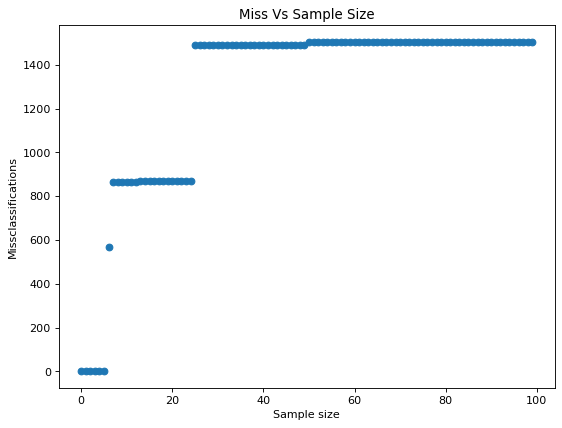

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
indx = np.arange(100)
plt.scatter(indx,misses)
plt.xlabel('Sample size')
plt.ylabel('Missclassifications')
plt.title('Miss Vs Sample Size')
plt.show()

In [9]:
'The optimal size to grow is 1-250'

'The optimal size to grow is 1-250'

In [10]:
def q1_2():
    global res_dict
    s = 125
    misses = np.zeros(20)
    # Generate different samples
    for i in range(20):
        X = generate_X(5000)
        training = generate_data(X,0.05)
        training = [[x] for x in training]
        dat = np.append(X,training,1)
        dat[:,0] = np.arange(len(dat))
        build(dat,s)
        misses[i] = calculate_miss(dat[:,-1])
        res_dict = defaultdict()
    return misses
misses = q1_2()
;

Sample Size:  5000
IG:  [0.00000000e+00 9.87018892e-02 1.04128490e-01 1.17485737e-01
 9.47522077e-02 9.78097991e-02 7.21042499e-05 2.65781885e-04
 1.17412932e-04 1.66745092e-05 1.95311216e-04 6.58350053e-05
 4.32126736e-04 4.89791385e-04 2.14522952e-04 5.75583597e-06]
Split at  3

Sample Size:  2490
IG:  [0.00000000e+00 1.17846986e-01 1.21983969e-01 0.00000000e+00
 1.16243688e-01 1.17929921e-01 3.85844417e-04 1.15756346e-03
 4.97105314e-06 3.34608802e-06 8.54446362e-04 2.10353900e-04
 3.62910772e-04 4.18210459e-04 6.09746232e-04 2.15119086e-04]
Split at  2

Sample Size:  1303
IG:  [0.00000000e+00 1.25277538e-01 0.00000000e+00 0.00000000e+00
 1.39804735e-01 1.39161974e-01 7.43426735e-05 2.96169877e-06
 3.98176594e-04 8.62372490e-04 4.45769707e-05 4.90146245e-06
 4.89043587e-06 1.83707002e-04 1.83688927e-04 1.04344115e-03]
Split at  4

Sample Size:  657
return 1

Sample Size:  646
IG:  [0.00000000e+00 2.83482135e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.35984053e-01 6.70452555e

IG:  [0.00000000e+00 1.10508437e-01 1.27932040e-01 1.12945748e-01
 0.00000000e+00 1.27150976e-01 4.69915221e-05 3.69098319e-04
 2.79913977e-04 1.28025923e-10 2.65343033e-06 3.84311031e-05
 7.00791743e-05 7.74434536e-06 8.60813213e-04 1.14030734e-04]
Split at  2

Sample Size:  1238
IG:  [0.00000000e+00 1.65858372e-01 0.00000000e+00 1.69457495e-01
 0.00000000e+00 2.07802171e-01 7.75198816e-06 3.27095451e-04
 5.44197481e-04 1.24697940e-03 8.87617689e-05 4.68315767e-04
 2.88313668e-05 4.82636189e-04 8.38384639e-04 1.89389469e-04]
Split at  5

Sample Size:  616
IG:  [0.00000000e+00 2.92400218e-01 0.00000000e+00 2.95455178e-01
 0.00000000e+00 0.00000000e+00 3.05344528e-03 1.18470866e-03
 5.80760749e-04 1.48238393e-05 4.40327429e-04 4.23745584e-03
 1.52793762e-04 2.00508789e-03 1.30847471e-03 1.30586836e-04]
Split at  3

Sample Size:  306
return 1

Sample Size:  310
IG:  [0.00000000e+00 9.98918835e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.28845256e-03 1.37966395e-03
 

Sample Size:  5000
IG:  [0.00000000e+00 9.45041236e-02 1.13156088e-01 1.03691659e-01
 1.01787241e-01 9.45926789e-02 1.26743504e-04 2.83864199e-06
 5.33028974e-04 1.08452951e-04 1.15892820e-05 6.67480061e-05
 5.68781626e-05 4.12521299e-05 1.39347043e-04 1.78399332e-05]
Split at  2

Sample Size:  2582
IG:  [0.00000000e+00 1.09267214e-01 0.00000000e+00 1.24967718e-01
 1.14102689e-01 1.22996233e-01 2.02651002e-05 2.96696733e-04
 1.01663327e-04 7.68470207e-05 8.13232954e-04 4.62993754e-05
 3.11248541e-06 2.73455505e-06 1.17134746e-06 2.53807572e-05]
Split at  3

Sample Size:  1282
IG:  [0.00000000e+00 1.30129153e-01 0.00000000e+00 0.00000000e+00
 1.35398819e-01 1.26206139e-01 3.27586023e-04 7.79892232e-07
 2.10254810e-04 9.42301990e-05 3.47325615e-03 1.90969552e-04
 8.89550708e-04 6.76057115e-04 2.23337306e-05 3.12013565e-04]
Split at  4

Sample Size:  655
return 1

Sample Size:  627
IG:  [0.00000000e+00 3.08870868e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.01097394e-01 3.44035221e

IG:  [0.00000000e+00 1.36036537e-01 1.04277035e-01 1.21630908e-01
 1.28090970e-01 0.00000000e+00 1.85764383e-05 5.22566664e-04
 4.36967340e-05 6.45052567e-09 6.55439860e-06 2.51413589e-04
 3.34566005e-08 1.30547793e-04 2.32669437e-04 1.69072739e-03]
Split at  1

Sample Size:  1233
IG:  [0.00000000e+00 0.00000000e+00 1.75381630e-01 1.83774659e-01
 2.07481319e-01 0.00000000e+00 1.00054288e-03 1.90711875e-05
 1.88153018e-03 6.66436090e-04 1.06065976e-04 2.93044443e-04
 1.44760987e-04 4.48731310e-04 5.83232256e-05 4.49467741e-03]
Split at  4

Sample Size:  623
IG:  [0.00000000e+00 0.00000000e+00 2.83760569e-01 3.01610570e-01
 0.00000000e+00 0.00000000e+00 3.71864925e-04 2.18722127e-03
 6.02234569e-03 2.78996731e-07 1.80443424e-04 8.35299646e-04
 1.16762517e-03 3.11335506e-03 1.56964497e-03 6.49822991e-03]
Split at  3

Sample Size:  323
return 1

Sample Size:  300
IG:  [0.00000000e+00 0.00000000e+00 9.99198354e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.60445868e-04 3.23362367e-03
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99781051e-01 0.00000000e+00 3.73347585e-04 1.11432898e-03
 1.03121044e-03 1.81342685e-04 1.43968162e-03 8.14118836e-04
 2.08583578e-04 2.47910690e-06 6.42130930e-03 1.97254016e-04]
Split at  4

Sample Size:  141
return 1

Sample Size:  146
return -1

Sample Size:  332
return -1

Sample Size:  646
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.04268204e-01 9.99705419e-02 1.10703945e-01
 9.86896413e-02 1.07094461e-01 4.13921474e-05 2.86548837e-04
 1.44447306e-04 3.40630340e-06 4.15429358e-04 2.15685028e-06
 7.67441682e-06 3.17361366e-06 5.66532961e-04 6.33404921e-05]
Split at  3

Sample Size:  2468
IG:  [0.00000000e+00 1.05758080e-01 1.30975609e-01 0.00000000e+00
 1.14865604e-01 1.24252154e-01 6.18639396e-04 2.18478676e-04
 4.24683198e-04 7.51325349e-05 9.64976177e-04 2.04954253e-04
 2.92957518e-04 2.35493434e-05 7.64729155e-04 4.98542275e-05]
Split at  2

Sample Size:  1256
IG:  [0.00000000e+00 1.23912923e-01 0.0

IG:  [0.00000000e+00 1.19288262e-01 0.00000000e+00 1.22694456e-01
 1.28011689e-01 1.36512879e-01 1.31866292e-04 3.57531997e-04
 2.76312506e-04 6.66156284e-04 1.19245742e-04 3.77179234e-04
 3.80460291e-05 4.43899340e-04 2.05022479e-04 1.07687612e-03]
Split at  5

Sample Size:  1222
IG:  [0.00000000e+00 1.90672336e-01 0.00000000e+00 2.04486345e-01
 1.71457520e-01 0.00000000e+00 3.43704034e-05 1.81125589e-04
 1.70202429e-04 1.12723774e-03 6.39113444e-04 3.17978829e-06
 2.66917928e-04 1.24352154e-06 9.99431122e-04 8.20406624e-04]
Split at  3

Sample Size:  600
IG:  [0.00000000e+00 2.87136679e-01 0.00000000e+00 0.00000000e+00
 2.94764767e-01 0.00000000e+00 8.13091280e-07 2.16321774e-04
 4.61110338e-04 1.85078147e-03 7.46688008e-04 2.96103551e-03
 7.11918353e-03 1.75904079e-04 6.75239509e-03 1.18261570e-03]
Split at  4

Sample Size:  313
return 1

Sample Size:  287
IG:  [0.00000000e+00 9.98028662e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.93816023e-04 2.14984353e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.99991363e-01 6.31548355e-03 2.10812645e-04
 7.79131770e-05 1.07533170e-03 7.31143175e-05 4.25468959e-04
 6.91477896e-04 7.22114278e-05 4.22036275e-04 1.05602478e-03]
Split at  5

Sample Size:  145
return 1

Sample Size:  144
return -1

Sample Size:  303
return -1

Sample Size:  631
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.00964070e-01 1.10510754e-01 1.09416252e-01
 1.02516139e-01 1.01200887e-01 2.22160893e-04 8.94316926e-05
 3.18679396e-05 2.65147478e-08 3.55212746e-04 1.34644052e-04
 2.17682611e-05 2.11292956e-07 2.74335622e-05 9.42617297e-05]
Split at  2

Sample Size:  2480
IG:  [0.00000000e+00 1.24713880e-01 0.00000000e+00 1.23418738e-01
 1.30857433e-01 1.14020832e-01 9.41220406e-06 5.63396625e-04
 3.83654472e-05 7.51488172e-04 6.38715507e-04 9.41440936e-04
 9.41220406e-06 1.91435551e-04 4.70587679e-05 9.77743506e-04]
Split at  4

Sample Size:  1266
IG:  [0.00000000e+00 1.37684035e-01 0.0

IG:  [0.00000000e+00 0.00000000e+00 1.28502230e-01 1.30879376e-01
 1.22394267e-01 9.70894392e-02 2.19603738e-04 5.81079790e-04
 2.70810408e-04 2.32080832e-04 2.63885024e-05 1.75014873e-03
 3.78307775e-04 2.81872885e-04 4.90383694e-05 2.17664011e-07]
Split at  3

Sample Size:  1202
IG:  [0.00000000e+00 0.00000000e+00 2.17211238e-01 0.00000000e+00
 1.82610418e-01 1.28848324e-01 1.19984628e-05 2.23556258e-03
 4.27837663e-05 7.21554499e-06 1.77637941e-04 8.97014974e-04
 6.22978309e-04 6.73324940e-04 3.80676609e-04 2.03861878e-04]
Split at  2

Sample Size:  598
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.84106682e-01 2.42506194e-01 7.83211931e-07 7.78749057e-04
 2.29651947e-03 1.71801276e-03 2.80115419e-04 3.05350560e-04
 4.12804586e-03 1.66450117e-03 1.04969636e-05 1.15075799e-03]
Split at  4

Sample Size:  313
return 1

Sample Size:  285
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.95296914e-01 1.28716853e-04 8.89249827e-05
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.97395460e-01 0.00000000e+00 5.07564242e-03 7.64773894e-03
 2.08438727e-03 5.66036333e-04 8.15176597e-05 4.56830103e-03
 1.85009158e-03 4.66145900e-04 2.87316331e-05 1.71581775e-03]
Split at  4

Sample Size:  133
return 1

Sample Size:  150
return -1

Sample Size:  307
return -1

Sample Size:  663
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.01175114e-01 1.09162517e-01 1.02703980e-01
 1.05983970e-01 9.87288117e-02 7.13063867e-06 7.10762641e-05
 1.32502177e-04 4.29957886e-04 2.29439447e-05 7.64925772e-06
 4.72200962e-05 6.65065946e-04 5.38994705e-05 2.65199488e-04]
Split at  2

Sample Size:  2507
IG:  [0.00000000e+00 1.19004839e-01 0.00000000e+00 1.17633035e-01
 1.26935302e-01 1.22089533e-01 4.60783441e-06 9.75258118e-06
 1.74372304e-04 7.57473976e-04 4.89447665e-05 1.78805283e-05
 1.07645247e-04 6.95872691e-04 5.31656110e-04 5.58092475e-04]
Split at  4

Sample Size:  1285
IG:  [0.00000000e+00 1.41697830e-01 0.0

IG:  [0.00000000e+00 1.22978052e-01 1.22297755e-01 1.18734785e-01
 0.00000000e+00 1.37489269e-01 3.80848721e-04 1.87150454e-05
 5.47721552e-05 4.24612622e-04 6.24882880e-04 1.55654051e-05
 1.85145960e-08 1.88901132e-04 2.56673423e-04 1.04831223e-05]
Split at  5

Sample Size:  1312
IG:  [0.00000000e+00 1.88725228e-01 2.03557152e-01 1.80391573e-01
 0.00000000e+00 0.00000000e+00 3.27136281e-04 4.29783521e-04
 1.35873508e-04 6.69142065e-04 6.04843448e-04 9.67357227e-04
 1.06534647e-04 9.64295031e-04 1.07162039e-04 9.73857661e-11]
Split at  2

Sample Size:  663
IG:  [0.00000000e+00 3.08073089e-01 0.00000000e+00 3.09558114e-01
 0.00000000e+00 0.00000000e+00 9.01136903e-04 1.64564760e-05
 2.26488004e-03 1.77561995e-03 6.78520463e-05 2.50824313e-04
 1.35976968e-04 5.08524271e-04 9.38604854e-05 1.22841541e-03]
Split at  3

Sample Size:  338
return 1

Sample Size:  325
IG:  [0.00000000e+00 9.99938535e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.33812064e-04 2.95924529e-03
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.99711442e-01 2.44528526e-03 1.14728078e-03
 5.08124642e-04 6.63712860e-03 2.57679018e-03 5.62511539e-04
 4.52037954e-04 1.71392623e-04 1.33985921e-02 1.27944014e-02]
Split at  5

Sample Size:  147
return 1

Sample Size:  153
return -1

Sample Size:  317
return -1

Sample Size:  653
return -1

Sample Size:  5000
IG:  [0.00000000e+00 1.06352339e-01 9.89051829e-02 9.80927958e-02
 1.05940962e-01 1.05217980e-01 2.52153400e-04 2.41112299e-04
 4.91598708e-04 2.22307914e-04 3.10753311e-04 3.82374101e-06
 1.50556801e-04 1.99605939e-06 4.59701463e-05 1.45657431e-04]
Split at  1

Sample Size:  2512
IG:  [0.00000000e+00 0.00000000e+00 1.17804287e-01 1.01093249e-01
 1.35067767e-01 1.34410449e-01 5.10705628e-04 2.68998132e-04
 6.98971641e-04 2.40219289e-04 1.16265379e-03 2.86628014e-05
 3.36914552e-05 4.56190523e-04 7.93561888e-08 3.91685271e-05]
Split at  4

Sample Size:  1271
IG:  [0.00000000e+00 0.00000000e+00 1.2

IG:  [0.00000000e+00 1.25427254e-01 1.11889410e-01 1.18826794e-01
 0.00000000e+00 1.21851872e-01 3.17667398e-04 7.94691882e-08
 1.02415724e-04 8.95276707e-04 1.45307976e-03 6.56827121e-05
 1.90140918e-04 1.36709538e-04 9.75876740e-05 6.81104163e-04]
Split at  1

Sample Size:  1331
IG:  [0.00000000e+00 0.00000000e+00 1.82519865e-01 2.12330524e-01
 0.00000000e+00 1.68395984e-01 4.42227074e-04 6.96633866e-05
 1.41617134e-03 2.04187935e-03 5.78887787e-03 2.96518699e-04
 3.92562475e-04 3.41374657e-04 1.14824178e-04 2.40348434e-03]
Split at  3

Sample Size:  630
IG:  [0.00000000e+00 0.00000000e+00 2.72390618e-01 0.00000000e+00
 0.00000000e+00 2.93566951e-01 3.34982217e-04 5.89049159e-05
 1.46183069e-05 5.12807722e-04 4.84966921e-03 1.26513029e-04
 1.42152405e-04 1.42152405e-04 8.99433085e-04 6.97236685e-05]
Split at  5

Sample Size:  331
return 1

Sample Size:  299
IG:  [0.00000000e+00 0.00000000e+00 9.97666895e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.29406462e-03 2.93526845e-06
 

Sample Size:  5000
IG:  [0.00000000e+00 1.07972902e-01 1.10130486e-01 1.09259976e-01
 1.08298888e-01 9.36109853e-02 3.21478038e-05 7.28896765e-05
 2.28903161e-04 1.17346590e-05 8.99595019e-04 4.21556000e-05
 4.86901489e-04 2.12522907e-04 2.31933141e-05 5.90629849e-04]
Split at  2

Sample Size:  2487
IG:  [0.00000000e+00 1.28325367e-01 0.00000000e+00 1.31373335e-01
 1.20025415e-01 1.08166205e-01 3.04361570e-05 7.44664470e-06
 8.65568895e-05 1.12199074e-08 1.16429511e-03 7.92189470e-04
 5.15963131e-04 2.39090977e-04 5.11141083e-05 1.12898111e-04]
Split at  3

Sample Size:  1242
IG:  [0.00000000e+00 1.32968134e-01 0.00000000e+00 0.00000000e+00
 1.17120632e-01 1.22034268e-01 2.34524817e-05 2.82997597e-05
 3.39499884e-04 5.84777058e-06 1.28425914e-03 3.56777545e-03
 3.84826169e-03 3.93200216e-04 2.33871652e-07 9.37631595e-05]
Split at  1

Sample Size:  660
return 1

Sample Size:  582
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.87993693e-01 3.05829079e-01 1.43521732e

IG:  [0.00000000e+00 2.07481319e-01 0.00000000e+00 1.83079269e-01
 0.00000000e+00 2.06659546e-01 1.47077583e-04 1.24573397e-03
 1.04041517e-03 6.42564995e-05 7.97317580e-04 1.31495200e-04
 3.97231413e-07 7.17626778e-04 5.31692044e-04 3.75501049e-06]
Split at  1

Sample Size:  623
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.83760569e-01
 0.00000000e+00 2.97055138e-01 5.44605505e-04 2.47761932e-03
 1.01819167e-03 5.51455830e-05 1.23953245e-03 2.22945567e-03
 9.96875832e-05 1.07559697e-03 2.78996731e-07 2.55816864e-04]
Split at  5

Sample Size:  320
return 1

Sample Size:  303
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.98671752e-01
 0.00000000e+00 0.00000000e+00 1.33952801e-03 2.88257638e-03
 2.73116131e-03 5.51047992e-04 4.21551411e-03 4.21551411e-03
 5.96129665e-04 2.36165491e-05 1.64530157e-03 5.96129665e-04]
Split at  3

Sample Size:  158
return 1

Sample Size:  145
return -1

Sample Size:  610
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.18486289e-01
 0.000

''

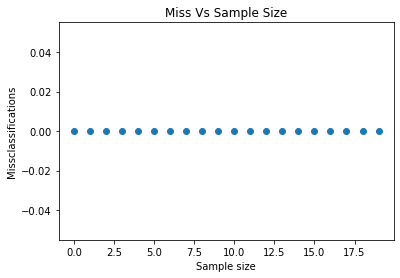

In [11]:
indx = np.arange(20)
plt.scatter(indx,misses)
plt.xlabel('Sample size')
plt.ylabel('Missclassifications')
plt.title('Miss Vs Sample Size')
plt.show()

In [12]:
'The optimal size is consistent'

'The optimal size is consistent'

In [ ]:
def q1_3():
    global res_dict
    s = 125
    misses = np.zeros(100)
    X = generate_X(5000)
    for i in range(100):
        # Change sigma
        training = generate_data(X,i*0.01)
        training = [[x] for x in training]
        dat = np.append(X,training,1)
        dat[:,0] = np.arange(len(dat))
        build(dat,s)
        misses[i] = calculate_miss(dat[:,-1])
        res_dict = defaultdict()
    return misses
misses = q1_3()

Sample Size:  5000
IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

Sample Size:  5000
IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e

IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 1.35392686e-01 0.00000000e+00 1.16652590e-01
 1.28944549e-01 1.14553011e-01 3.96800290e-04 3.08500478e-05
 1.39318143e-04 6.22227903e-05 2.76533906e-05 5.97774610e-04
 8.50863337e-06 4.97391325e-05 3.92071130e-04 3.18906987e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 1.08904724e-01 1.11723749e-01 9.97879355e-02
 1.01222438e-01 1.07277916e-01 3.03644204e-05 1.09995471e-04
 4.13013958e-05 4.61478242e-06 1.04269689e-04 4.13635370e-04
 9.09599089e-05 2.54079259e-04 7.98190499e-06 1.62701630e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

IG:  [0.00000000e+00 1.09375086e-01 1.12200670e-01 9.93491703e-02
 1.00764807e-01 1.06821490e-01 3.02026724e-05 9.63787763e-05
 3.30948481e-05 7.87506735e-06 1.18524942e-04 4.14031315e-04
 1.04282328e-04 2.54259845e-04 7.86246462e-06 1.13083951e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.34604966e-01 0.00000000e+00 1.21721026e-01
 1.11806506e-01 1.30546519e-01 2.41900739e-04 7.21962704e-04
 3.21744164e-05 1.58161222e-05 9.17903311e-04 7.59110168e-05
 1.37597995e-04 1.60260789e-04 2.61098417e-04 5.56573759e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.31633982e-01
 1.17767317e-01 1.33493561e-01 8.85667334e-05 2.22281095e-03
 2.78448943e-04 5.85210759e-05 1.91922634e-03 8.07966530e-05
 1.87759491e-03 2.87486202e-05 1.45632266e-05 2.29136806e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20748830e-01
 2.74400575e-01 0.00000000e+00 6.70269439e-05 3.04526329e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 4.46511508e-03 6.97455301e-03 3.73247016e-03 1.97314188e-03
 4.93285384e-04 4.93116701e-04 7.96107969e-03 1.97720558e-03]
Split at  5

Sample Size:  153
return 1

Sample Size:  153
return -1

Sample Size:  635
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03319110e-01
 0.000

IG:  [0.00000000e+00 1.10303337e-01 1.12666034e-01 9.88886864e-02
 9.99007938e-02 1.05883097e-01 3.86813217e-05 1.24312802e-04
 3.28988170e-05 4.80367814e-06 1.50245560e-04 4.12845628e-04
 1.04584546e-04 2.75829676e-04 1.25845452e-05 1.61303752e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.37492914e-01 0.00000000e+00 1.19902825e-01
 1.10108787e-01 1.28631489e-01 1.98190108e-04 8.05259216e-04
 3.21499509e-05 1.63392122e-05 1.10928800e-03 7.46171082e-05
 1.73900814e-04 1.58582621e-04 2.59270361e-04 7.95305653e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27545224e-01
 1.14125403e-01 1.29344492e-01 2.03957200e-04 2.72240830e-03
 2.79772007e-04 5.75871139e-05 2.85232707e-03 8.60254756e-05
 1.58551695e-03 2.46827348e-05 1.45649394e-05 1.28872964e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.09302015e-01
 2.64788976e-01 0.00000000e+00 2.53479492e-04 3.99990618e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.28586462e-04 9.54435747e-03
 4.78265084e-03 1.05939273e-06 9.95823353e-03 5.19748661e-05
 2.40454400e-03 4.78265084e-03 1.05939273e-06 3.73654914e-03]
Split at  10

Sample Size:  83
Size Threshold Met
+1:  1 -1:  82
return -1

Sample Size:  58
Size Threshold Met
+1:  3 -1:  55
return -1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.72848046e-01
 1.88715212e-01 1.97663107e-01 1.17879390e-04 5.88133697e-04
 1.32100559e-03 1.17675705e-04 1.85923274e-03 1.85513831e-03
 1.05015773e-03 1.62539888e-05 1.74042040e-03 5.93945249e-09]
Split at  5

Sample Size:  640
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.95767084e-01
 3.14103519e-01 0.00000000e+00 2.30917862e-06 3.38199384e-04
 7.46511414e-04 3.99490220e-04 4.14903326e-03 1.22587078e-03
 1.23866186e-03 3.78886780e-05 2.53999465e-03 1.01998960e-05]
Split at  4

Sample Size:  325
return 1

Sample Size:  315
IG:

IG:  [0.00000000e+00 1.38391145e-01 0.00000000e+00 1.14891542e-01
 1.27034587e-01 1.12768398e-01 3.37242043e-04 5.08524789e-05
 1.78176087e-04 1.21208667e-04 4.56642039e-05 6.74441875e-04
 8.95230619e-06 7.24778294e-05 3.32611245e-04 3.26259306e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90040748e-01
 1.98917116e-01 1.86191843e-01 8.76894173e-04 5.19750926e-04
 6.12993711e-06 2.72037148e-04 2.08965090e-03 2.36767449e-03
 8.60954736e-05 1.15592040e-04 1.78631004e-04 2.81718337e-05]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.13331805e-01
 0.00000000e+00 2.99228628e-01 2.72555133e-05 2.72555133e-05
 3.76945641e-04 9.10373299e-03 8.70635434e-04 1.87653320e-05
 6.75747340e-04 6.62439233e-04 5.12759717e-05 1.36240754e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 4.93116701e-04 1.23268638e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.15051259e-01
 1.24668202e-01 1.17902594e-01 2.93214519e-04 2.70303312e-03
 2.50314031e-04 1.47331995e-04 3.05158062e-03 1.31572658e-03
 2.30242511e-04 3.24164575e-05 2.71762836e-04 1.31572658e-03]
Split at  4

Sample Size:  583
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.73096292e-01
 0.00000000e+00 3.09131835e-01 4.10769643e-04 2.98535381e-03
 6.80289598e-04 4.63936891e-04 6.73192223e-03 2.34253159e-03
 5.05802599e-05 7.79190537e-05 4.63936891e-04 1.52125680e-03]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.22315088e-01
 0.00000000e+00 0.00000000e+00 5.24132833e-04 3.62333674e-03
 1.00506411e-03 4.69794152e-03 1.04754810e-02 1.04072252e-02
 5.58194858e-04 2.53200944e-03 6.22065612e-04 1.17122028e-02]
Split at  3

Sample Size:  134
IG:  [0.         0.         0.         0.         0.         0.
 0.00320714 0.01609666 0.02325494 0.00170959 0.01732351 0.02696622
 0.00113932 0.00221391 0.0

IG:  [0.00000000e+00 1.13865332e-01 1.14823516e-01 9.69200895e-02
 9.65661262e-02 1.02480474e-01 2.66589408e-05 1.03074663e-04
 6.60677282e-05 1.24904743e-06 8.44577991e-05 4.56349676e-04
 1.11388706e-04 3.11225126e-04 9.95096484e-06 2.55758297e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.42618724e-01 0.00000000e+00 1.18998401e-01
 1.06141838e-01 1.24302548e-01 3.41348393e-04 8.92034129e-04
 7.40305167e-05 1.29771015e-06 9.24626520e-04 5.08771679e-05
 1.37262570e-04 2.87756395e-04 2.58359470e-04 1.40417715e-04]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.22467193e-01
 1.09600759e-01 1.24191807e-01 1.67866865e-07 3.06355378e-03
 2.12613380e-04 1.99355760e-04 1.89591332e-03 9.22414439e-06
 1.49325748e-03 1.22648085e-04 2.61184084e-06 2.90108304e-05]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.95258375e-01
 2.52974121e-01 0.00000000e+00 4.89734950e-05 4.67746198e-03


IG:  [0.00000000e+00 1.43965936e-01 0.00000000e+00 1.12058780e-01
 1.23999144e-01 1.08872672e-01 3.91425297e-04 1.79897049e-05
 1.08736167e-04 4.46525344e-05 5.29962036e-06 8.40186009e-04
 2.07717830e-05 3.03531174e-05 1.87403351e-04 5.28097628e-05]
Split at  1

Sample Size:  1260
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90013919e-01
 1.98934620e-01 1.83749928e-01 7.25791533e-04 6.53290044e-04
 2.79395691e-05 2.67241497e-04 2.35115629e-03 2.36259143e-03
 8.76093449e-05 6.51559418e-05 1.15089161e-04 7.04271549e-06]
Split at  4

Sample Size:  625
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10736480e-01
 0.00000000e+00 2.96764826e-01 3.87009213e-06 3.87009213e-06
 2.61901590e-04 9.74279324e-03 1.07726925e-03 1.65941693e-06
 5.22532880e-04 5.07157062e-04 1.61935709e-05 2.19342065e-04]
Split at  3

Sample Size:  319
return 1

Sample Size:  306
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.71552983e-01 7.68562152e-04 2.78586483e-04
 

IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.62895740e-01
 0.00000000e+00 2.97415523e-01 2.07469998e-04 4.05282432e-03
 1.43701017e-04 4.50383969e-04 9.39242931e-03 7.97747238e-04
 2.25531906e-04 8.44971873e-05 1.24926799e-03 1.10204294e-03]
Split at  5

Sample Size:  268
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.50114535e-01
 0.00000000e+00 0.00000000e+00 1.03068603e-03 5.86235040e-03
 4.02833701e-05 4.44994623e-03 1.66316186e-02 4.16218425e-03
 7.09485823e-05 2.48054815e-03 2.48054815e-03 9.21337668e-03]
Split at  3

Sample Size:  134
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.93772352e-05 2.71828805e-04
 6.53354081e-04 6.53354081e-04 4.17253329e-03 4.01755683e-03
 1.88591967e-03 1.18875712e-03 1.18875712e-03 2.74956714e-03]
Split at  10

Sample Size:  79
Size Threshold Met
+1:  76 -1:  3
return 1

Sample Size:  55
Size Threshold Met
+1:  51 -1:  4
return 1

Sample Size:  134
return -1

Sample Size:  315
retur

IG:  [0.00000000e+00 1.16497523e-01 1.18442243e-01 9.36395909e-02
 9.42188707e-02 9.95442733e-02 4.80041302e-05 4.97648119e-05
 2.54508767e-05 4.99639137e-06 7.86350984e-05 5.61572320e-04
 1.50678546e-04 2.75456138e-04 1.28875774e-05 2.18878324e-05]
Split at  2

Sample Size:  2519
IG:  [0.00000000e+00 1.48069381e-01 0.00000000e+00 1.13637001e-01
 1.04258485e-01 1.20922514e-01 2.88666663e-04 6.54407078e-04
 1.75474318e-05 1.82540855e-05 6.86852360e-04 1.63841800e-04
 1.73250505e-04 1.91400091e-04 2.52937592e-04 7.91277873e-05]
Split at  1

Sample Size:  1259
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.13417238e-01
 1.01532783e-01 1.15009485e-01 5.42214654e-05 2.10011036e-03
 4.60458434e-04 5.44374066e-05 1.50096364e-03 5.76881971e-04
 1.46685193e-03 1.23641502e-05 7.00648547e-05 1.75570452e-04]
Split at  5

Sample Size:  667
return 1

Sample Size:  592
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.70682439e-01
 2.32240573e-01 0.00000000e+00 2.90193299e-05 2.90324543e-03


IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.70682439e-01
 2.32240573e-01 0.00000000e+00 7.71339313e-05 1.57226049e-03
 3.84507868e-05 2.54220554e-04 1.65509686e-03 2.02481572e-06
 3.00293147e-03 2.07065153e-04 6.55236633e-04 5.18247861e-04]
Split at  3

Sample Size:  313
return 1

Sample Size:  279
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.11430140e-01 0.00000000e+00 1.37374192e-03 4.07453503e-03
 3.00740815e-03 6.99288149e-03 3.02428662e-06 1.37816429e-04
 5.93060661e-03 1.28783082e-04 7.80494447e-05 1.14742556e-04]
Split at  4

Sample Size:  138
return 1

Sample Size:  141
IG:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.07569193e-03 3.20937947e-03
 6.06328852e-04 1.24331944e-02 2.20998512e-04 4.00727302e-04
 8.91148055e-03 6.06328852e-04 1.14453630e-03 3.81221050e-05]
Split at  9

Sample Size:  70
Size Threshold Met
+1:  12 -1:  58
return -1

Sample Size:  71
Size Threshold Met
+1:  6 -1:  65
retur

In [ ]:
indx = np.arange(100)
plt.scatter(indx,misses)
plt.xlabel('Sigma')
plt.ylabel('Missclassifications')
plt.title('Miss Vs Sigma')
plt.show()

In [ ]:
# Making changes to build to get the desired result for 1.3
global df 
df = pd.DataFrame()
global extra
extra = 0
def build_13(half,size):
    #print(half)
    global df
    global extra
    half = half.astype(int)
    if len(half) == 0:
        return
    if len(half) == 1:
        df = df.append(pd.DataFrame(half))
        return half
    # No. of Yi=+1 in the data set
    count = np.count_nonzero(half[:,-1:] == 1)
    count2 = np.count_nonzero(half[:,-1:] == -1)
    # If sample size threshold met
    if len(half) <= size:
        # +1 is majority
        if count >= count2:
            res = 1
        # Otherwise => -1 majority
        else:
            res = -1
        half[:,-1] = res
        df = df.append(pd.DataFrame(half))
        return half
    # If all Yi's are +1 or -1
    if count == len(half) or count == 0:
        df = df.append(pd.DataFrame(half))
        return half
    # If we did not hit the stopping condition:
    first_half,second_half,split_index,IG = split_data(half)
    if split_index > 5:
        extra += 1
    build_13(first_half,size)
    build_13(second_half,size)

In [ ]:
def q1_3():
    global df
    global extra
    s = 125
    extras = np.zeros(100)
    X = generate_X(5000)
    for i in range(100):
        # Change sigma
        training = generate_data(X,i*0.01)
        training = [[x] for x in training]
        dat = np.append(X,training,1)
        dat[:,0] = np.arange(len(dat))
        build_13(dat,s)
        df = df.dropna()
        extras[i] = extras[i] + (len(df.index)-5000) + extra
        df = pd.DataFrame()
        extra = 0
    return extras
extras = q1_3()

In [ ]:
indx = np.arange(100)
plt.scatter(indx,extras)
plt.xlabel('Sigma')
plt.ylabel('Irrelevant Features')
plt.title('Irrelevant Features Vs Sigma')
plt.show()

In [ ]:
from collections import defaultdict
global res_dict 
res_dict = defaultdict()
def build_21(half,size):
    global res_dict
    #half = half.astype(int)
    print('Sample Size: ', len(half))
    #print(half)
    #print(half.shape)
    if len(half) == 0:
        print('return')
        print()
        return
    if len(half) == 1:
        print('return',half[0][-1])
        print()
        if half[0][0] in res_dict:
            return
        res_dict[int(half[0][0])] = half[0][-1]
        return half
    # No. of Yi=+1 in the data set
    count = np.count_nonzero(half[:,-1:] == 1)
    count2 = np.count_nonzero(half[:,-1:] == -1)
    # If sample size threshold met
    if len(half) <= size:
        print('Size Threshold Met')
        print('+1: ',count,'-1: ', count2)
        # Probability of +1
        res =  count/(count+count2)
        half[:,-1] = res
        print('return',res)
        print()
        for i in range(len(half)):
            if half[i][0] not in res_dict:
                res_dict[int(half[i][0])] = half[i][-1]
        return half
    # If all Yi's are +1 or -1
    if count == len(half) or count == 0:
        print('return',half[0][-1])
        print()
        for i in range(len(half)):
            if half[i][0] not in res_dict:
                res_dict[int(half[i][0])] = half[i][-1]
        return half
    # If we did not hit the stopping condition:
    first_half,second_half,split_index,IG = split_data(half)
    print('IG: ',IG)
    print('Split at ', split_index)
    print()
    build_21(first_half,size)
    build_21(second_half,size)

In [ ]:
def log_error(dat):
    global res_dict
    sum = 0
    for i in range(1,len(dat)+1):
        y = dat[i-1][-1]
        f = res_dict[i-1]
        if f != 1 and f != 0:
            sum = sum -y*math.log(f) - (1-y)*math.log(1-f)
    sum = sum/len(dat)
    return sum

def q2_1():
    global res_dict
    X = generate_X(5000)
    training = generate_data(X,0.05)
    training = [[x] for x in training]
    dat = np.append(X,training,1)
    dat[:,0] = np.arange(len(dat))
    log_errors = np.zeros(100)
    for i in range(0,5000,50):
        res_dict = defaultdict()
        dat2 = dat.copy()
        build_21(dat2,i)
        dat2[dat2 == -1] = 0
        #print("res: ", len(res_dict))
        for key in res_dict.keys():
            if res_dict[key] == -1:
                res_dict[key] = 0
        log_errors[i//50] = log_error(dat2)
    return log_errors
log_errors = q2_1()

In [ ]:
indx = np.arange(100)
plt.scatter(indx*50,log_errors)
plt.xlabel('Sample Size')
plt.ylabel('Log Errors')
plt.title('Log Errors Vs Sample Size')
plt.show()

In [ ]:
'The error is similar to previous but has more consistency among groups, sample size remains same'

In [ ]:
# Sigmoid Function
def sigmoid(x):
    return 1/(1 + np.exp(-x))
# Regression Function
def F(w,x):
    return sigmoid(np.dot(w,x))
# Log Reg using SGD
def log_reg(dat,alpha_t):
    # Stores Current Prediction
    global res_dict
    # List of errors until time t
    errors = []
    # Pick an initial guess
    w_t = np.ones(16)
    # Until Convergence:
    for i in range(5000):
        # Choose a random index 
        a = np.random.choice(5000)
        x = dat[a,:-1]
        y = dat[a,-1:]
        res_dict = defaultdict()
        # Update predictions for w_t
        for i in range(len(dat)):
            res_dict[i] = F(w_t,dat[:,0:16][i])
        # Add errors to error log
        errors.append(log_error(dat))
        #print(errors[len(errors)-1])
        # If error is insignificant , break
        if errors[len(errors)-1] < 0.001:
            break
        # Update w_t
        w_t_1 = w_t - alpha_t * (F(w_t,x)-y) * x
        w_t = w_t_1
    return errors,w_t

X = generate_X(5000)
training = generate_data(X,0.05)
training = [[x] for x in training]
dat = np.append(X,training,1)
dat[:,0] = 1
dat[dat == -1] = 0
errors,wt = log_reg(dat,0.05)



In [ ]:
indx = np.arange(len(errors))
plt.scatter(indx,errors)
plt.xlabel('Time')
plt.ylabel('Log Errors')
plt.title('Log Errors Vs Time')
plt.show()

In [ ]:
def testing_dat(wt):
    global res_dict
    # Generate testing data
    X = generate_X(500)
    testing = generate_data(X,0.05)
    testing = [[x] for x in testing]
    dat = np.append(X,testing,1)
    dat[:,0] = 1
    dat[dat == -1] = 0
    # Use result from above to get predictions
    for i in range(500):
        res_dict[i] = F(wt,dat[i,:-1])
    # Calculate error
    error = log_error(dat)
    return error
err = testing_dat(wt)

In [ ]:
print(err)

In [ ]:
'The error is consistent for training and teting so overfitting might not be an issue'

In [ ]:
'''
I think regression is better because tree comes to conclusion fast, sometimes if one variable is +1 it might claim all data is +1
Same for reducing influence of irrelevant features, can be measured by comparing the difference of adding one feature vs not having it in the model
'''